## Exploratory Data Analysis (EDA)

**Optional notebook** for understanding the data before modeling.

This notebook:
- Downloads data from Toronto OpenData
- Explores data structure and patterns
- Visualizes trends and seasonality
- Provides insights for feature engineering

**Note:** Feature engineering is done in `02_data_preparation.ipynb`. This notebook is for exploration only.

In [ ]:
# import requests

# base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
# package_id = "daily-shelter-overnight-service-occupancy-capacity"

# # Get package metadata
# package = requests.get(f"{base_url}/api/3/action/package_show", params={"id": package_id}).json()

# # Find the first active resource
# for resource in package["result"]["resources"]:
#     if resource["datastore_active"]:
#         resource_id = resource["id"]
#         csv_url = f"{base_url}/datastore/dump/{resource_id}"
        
#         # Download entire CSV at once
#         csv_text = requests.get(csv_url).text
#         with open("../data/sheltersdata.csv", "a", encoding="utf-8") as f:
#             f.write(csv_text)
#         print("All data saved as data/shelters.csv")
        
import requests

# --- (Your setup code like 'base_url' and 'package') ---

output_file = "../data/sheltersdata.csv"
is_first_file = True # Use a flag to track the first write

print(f"Starting download to {output_file}...")

# Open the file *once* before the loop in write mode
with open(output_file, "w", encoding="utf-8") as f:
    for resource in package["result"]["resources"]:
        if resource["datastore_active"]:
            resource_id = resource["id"]
            csv_url = f"{base_url}/datastore/dump/{resource_id}"
            
            print(f"Downloading data from resource {resource_id}...")
            csv_text = requests.get(csv_url).text

            if is_first_file:
                # 1. For the first file, write the whole thing (headers included)
                f.write(csv_text)
                is_first_file = False # Unset the flag
            else:
                # 2. For all other files, skip their header line
                lines = csv_text.splitlines()
                if len(lines) > 1: # Make sure there's data to write
                    # Write from the second line (index 1) onwards
                    # We add our own newline to ensure separation
                    f.write("\n" + "\n".join(lines[1:]))

print(f"All data saved correctly to {output_file}")

Starting download to ../data/sheltersdata.csv...
All data saved correctly to ../data/sheltersdata.csv


In [30]:
import pandas as pd

# Load CSV
df = pd.read_csv("../data/sheltersdata.csv")

# Convert date
df['OCCUPANCY_DATE'] = pd.to_datetime(df['OCCUPANCY_DATE'], format='mixed')

# Quick look
print(df.head())
print(df.info())


   _id OCCUPANCY_DATE  ORGANIZATION_ID         ORGANIZATION_NAME  SHELTER_ID  \
0    1     2025-01-01               24  COSTI Immigrant Services          40   
1    2     2025-01-01               24  COSTI Immigrant Services          40   
2    3     2025-01-01               24  COSTI Immigrant Services          40   
3    4     2025-01-01               24  COSTI Immigrant Services          40   
4    5     2025-01-01               24  COSTI Immigrant Services          40   

            SHELTER_GROUP  LOCATION_ID               LOCATION_NAME  \
0  COSTI Reception Centre       1320.0   COSTI Hotel Program Dixon   
1  COSTI Reception Centre       1320.0   COSTI Hotel Program Dixon   
2  COSTI Reception Centre       1051.0      COSTI Reception Centre   
3  COSTI Reception Centre       1051.0      COSTI Reception Centre   
4  COSTI Reception Centre       1114.0  COSTI Uptown Hotel Program   

    LOCATION_ADDRESS LOCATION_POSTAL_CODE  ... OCCUPIED_BEDS UNOCCUPIED_BEDS  \
0      640 Dixon R

## Key Observations:

- Some rows only have room-based capacity, others bed-based.

 - Beds are a more complete data point, so we focus on `OCCUPANCY_RATE_BEDS` for regression and classification.

In [31]:
# Quick data quality check
print("Data quality check:")
print(f"Total rows: {len(df)}")
print(f"Rows with OCCUPIED_BEDS: {df['OCCUPIED_BEDS'].notna().sum()}")
print(f"Rows with OCCUPANCY_RATE_BEDS: {df['OCCUPANCY_RATE_BEDS'].notna().sum()}")
print(f"\nOvercapacity rate (>95%): {(df['OCCUPANCY_RATE_BEDS'] > 95).mean():.2%}")
df.info()

Data quality check:
Total rows: 242658
Rows with OCCUPIED_BEDS: 165802
Rows with OCCUPANCY_RATE_BEDS: 165802

Overcapacity rate (>95%): 55.50%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242658 entries, 0 to 242657
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id                     242658 non-null  int64         
 1   OCCUPANCY_DATE          242658 non-null  datetime64[ns]
 2   ORGANIZATION_ID         242658 non-null  int64         
 3   ORGANIZATION_NAME       242658 non-null  object        
 4   SHELTER_ID              242658 non-null  int64         
 5   SHELTER_GROUP           242442 non-null  object        
 6   LOCATION_ID             242213 non-null  float64       
 7   LOCATION_NAME           241167 non-null  object        
 8   LOCATION_ADDRESS        234053 non-null  object        
 9   LOCATION_POSTAL_CODE    234079 non-null  object        
 10  LOCATION_

## Exploratory Visualizations

The following visualizations help understand patterns in the data. Feature engineering is done in `02_data_preparation.ipynb`.

In [32]:
# Create temporal features for visualization
df['day_of_week'] = df['OCCUPANCY_DATE'].dt.dayofweek
df['month'] = df['OCCUPANCY_DATE'].dt.month

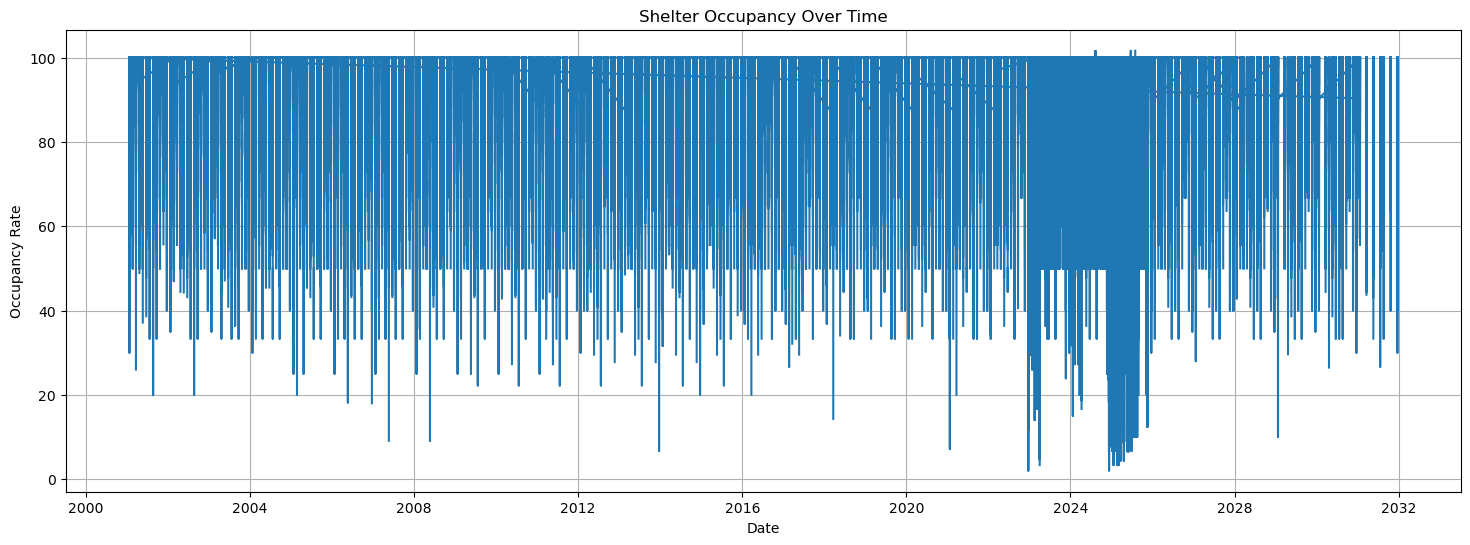

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))

plt.plot(df['OCCUPANCY_DATE'], df['OCCUPANCY_RATE_BEDS'])
plt.title("Shelter Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.grid(True)
plt.show()


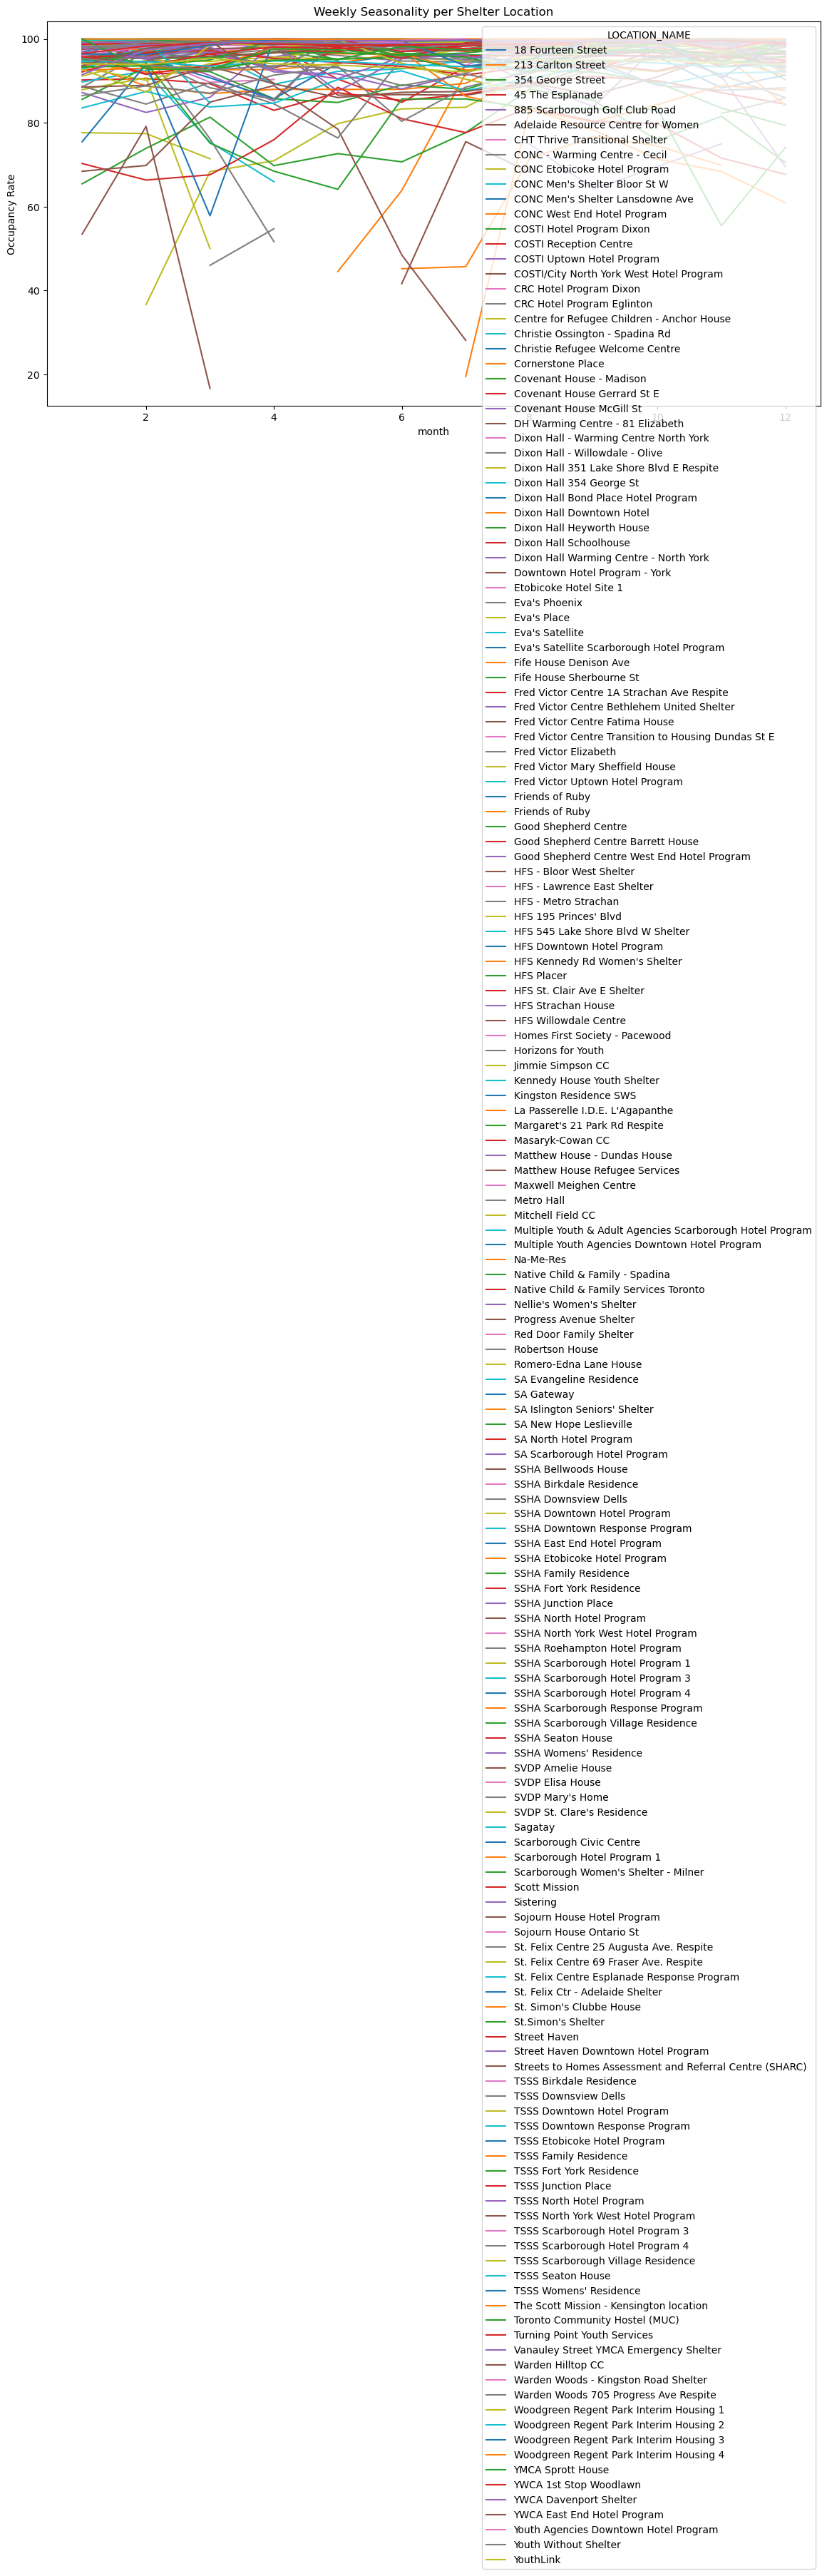

In [37]:
weekly = df.groupby(['LOCATION_NAME', 'month'])['OCCUPANCY_RATE_BEDS'].mean()
weekly.unstack().T.plot(figsize=(14,7))
plt.title("Weekly Seasonality per Shelter Location")
plt.ylabel("Occupancy Rate")
plt.show()



In [38]:
### Monthly Patterns


In [39]:
# Visualization removed - cyclical encoding visualization moved to 02_data_preparation.ipynb


## Summary

This EDA notebook provides insights into the data. For the actual ML pipeline, proceed to:
1. `02_data_preparation.ipynb` - Feature engineering and data preparation
2. `03_train_test_split.ipynb` - Split data
3. `04_model_training.ipynb` - Train models
4. `05_model_evaluation.ipynb` - Evaluate models


In [40]:
# End of EDA - proceed to 02_data_preparation.ipynb for feature engineering
